In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats, semplot, report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import pingouin as pg

In [2]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [3]:
df['q4812'].value_counts()

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

In [4]:
# df = df[df['school'] == '고등학생']
# df.head(3)

In [5]:
len(df)

5376

In [6]:
def null0(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df

In [7]:
def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df

category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}
happy_map = {
'매우 행복하다' : 4,
'대체로 행복한 편이다' : 3,
'모르겠다' : 2,
'별로 행복하지 않은 편이다' : 1,
'전혀 행복하지 않다' : 0
}
how_happy_map = {
'매우 행복하다' : 4,
'약간 행복하다' : 3,
'보통이다' : 2,
'약간 불행하다' : 1,
'매우 불행하다' : 0
}
yes_or_no_map = {
'예' : 1,
'아니오' : 0
}
is_or_not_map = {
    '있다' : 1,
    '없다' : 0
}
is_or_not_map2 = {
    '있다' : 2,
    '없다' : 1
}
how_much_is_map = {
    '전혀 없다' : 0,
    '1~2번 있다' : 1,
    '3~4번 있다' : 2,
    '5번 이상 있다' : 2
}
how_high_map = {
    '상의 상' : 2,
    '상의 하': 2,
    '중의 상': 1,
    '중의 하': 1,
    '하의 상': 0, 
    '하의 하': 0
}

In [8]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df

In [9]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df
def applicable_is_the_worst(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '전혀 그렇지 않다'})
    return df
def applicable_is_the_best(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '매우 그렇다'})
    return df

In [10]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [11]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [12]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [13]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df)
    return model

In [14]:
def calculate_bmi(df, height, weight):
    df[height] = pd.to_numeric(df[height], errors='coerce')
    df[weight] = pd.to_numeric(df[weight], errors='coerce')
    
    df['bmi'] = df[weight] / ((df[height] / 100) ** 2)
    df['bmi'] = df['bmi'].round(2)
    return df

In [15]:
# 표준화 계수 계산 함수
def standardize_estimates(df, data):
    std_estimates = []
    for _, row in df.iterrows():
        if row['op'] == '~':  # 회귀 계수
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                y_std = np.std(data[row['lhs']], ddof=1)
                std_beta = row['Estimate'] * (x_std / y_std)
                std_estimates.append(std_beta)
            except KeyError:
                std_estimates.append(np.nan)
        elif row['op'] == '=~':  # 요인 부하량
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                std_estimates.append(row['Estimate'] * x_std)
            except KeyError:
                std_estimates.append(np.nan)
        else:
            std_estimates.append(np.nan)
    df['std_estimate'] = std_estimates
    return df

# 학업압박

In [16]:
df_edu = df[['q071','q072', 'q073', 'q074'] + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, ['q071', 'q072', 'q073', 'q074'], category4_map)
df_edu = encoding(df_edu, ['q485', 'q486','q487', 'q488'], category5_map)

In [17]:
scaler = MinMaxScaler()
df_edu[['q071', 'q072', 'q073', 'q074', 'q485', 'q486','q487', 'q488']] = scaler.fit_transform(df_edu[['q071', 'q072', 'q073', 'q074', 'q485', 'q486','q487', 'q488']])

In [18]:
model_desc = """
exam_anxiety =~ q072 + q073
academic_stress =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety
"""

In [19]:
df_edu['wt'] = df['wt']
observed_vars = ['q072', 'q073', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

적합도 지표:
                       Value
DoF                7.000000
DoF Baseline      15.000000
chi2             241.352506
chi2 p-value       0.000000
chi2 Baseline  14606.987426
CFI                0.983940
GFI                0.983477
AGFI               0.964593
NFI                0.983477
TLI                0.965585
RMSEA              0.078922
AIC               27.910211
BIC              120.166009
LogLik             0.044894 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err      z-value  \
0     academic_stress   ~  academic_pressure  1.000000         -            -   
1        exam_anxiety   ~  academic_pressure  0.968809  0.000184  5251.669584   
2                q072   ~       exam_anxiety  1.000000         -            -   
3                q073   ~       exam_anxiety  0.833512  0.017367    47.993422   
4                q485   ~    academic_stress  1.000000         -            -   
5                q486   ~    academic_stress  1.010153   0.01667    60.59

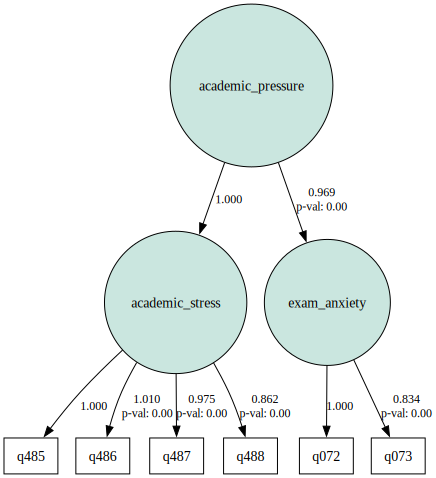

In [20]:
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\academic_pressure.png')

In [21]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]
df['academic_stress'] = factor_scores["academic_stress"]
df['exam_anxiety'] = factor_scores["exam_anxiety"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure academic_stress exam_anxiety  
0         -0.151269        0.002721    -0.473646  
1         -0.148003       -0.143

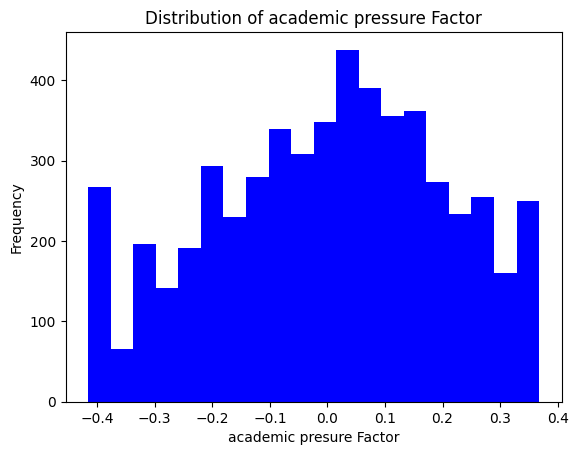

In [22]:
plt.hist(df["academic_pressure"], bins=20, color='blue')
plt.title("Distribution of academic pressure Factor")
plt.xlabel("academic presure Factor")
plt.ylabel("Frequency")
plt.show()

# 인간 관계

In [23]:
df_rel = df[['q05','q134', 'q136', 'q489','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225', 'q132']]
df_rel.columns

Index(['q05', 'q134', 'q136', 'q489', 'q061', 'q062', 'q161', 'q162', 'q163',
       'q164', 'q171', 'q172', 'q173', 'q174', 'q224', 'q225', 'q132'],
      dtype='object')

In [24]:
df_rel['q172'].value_counts()

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

In [25]:
df_rel['q05'].value_counts()

q05
매우 그렇다       2052
조금 그렇다       1530
보통이다         1361
별로 그렇지 않다     297
전혀 그렇지 않다     136
Name: count, dtype: int64

In [26]:
df_rel = not_applicable(df_rel, ['q171','q172','q162', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = applicable_is_the_best(df_rel, ['q132', 'q134'])
df_rel = applicable_is_the_worst(df_rel, ['q136'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132', 'q134', 'q489'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q134,q136,q489,q061,q062,q161,q162,q163,q164,q171,q172,q173,q174,q224,q225,q132
0,1.00,1.0,1.0,1.0,0.75,0.00,1.0,1.0,1.00,0.25,1.0,1.0,1.00,0.25,0.50,0.25,1.0
1,0.75,1.0,1.0,1.0,0.75,0.25,1.0,1.0,1.00,0.75,1.0,1.0,1.00,0.75,0.75,0.75,1.0
2,1.00,1.0,0.0,0.5,1.00,1.00,1.0,1.0,0.75,0.75,0.5,0.5,0.75,0.50,0.50,1.00,1.0


In [27]:
model_desc = """
friend_rel =~ q132 + q134 + q136 + q489 + q05
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel

father_rel ~~ mother_rel
"""

In [28]:
df_rel['wt'] = df['wt']
observed_vars = ['q05','q132','q134', 'q136','q489', 'q061', 'q062','q161','q163','q171','q173','q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

적합도 지표:
                       Value
DoF               58.000000
DoF Baseline      78.000000
chi2            1694.312874
chi2 p-value       0.000000
chi2 Baseline  19715.332020
CFI                0.916673
GFI                0.914061
AGFI               0.884427
NFI                0.914061
TLI                0.887940
RMSEA              0.072449
AIC               65.369675
BIC              282.829771
LogLik             0.315162 


모수 추정치:
            lval  op         rval      Estimate      Std. Err    z-value  \
0    father_rel   ~   parent_rel  1.000000e+00             -          -   
1    mother_rel   ~   parent_rel  8.175802e-01      0.036571  22.355943   
2    friend_rel   ~    human_rel  1.000000e+00             -          -   
3   teacher_rel   ~    human_rel  1.286158e+00      0.058059  22.152465   
4    parent_rel   ~    human_rel  9.256772e-01      0.048958  18.907682   
5     group_rel   ~    human_rel  1.630967e+00      0.078284  20.833919   
6          q132   ~   friend_rel  

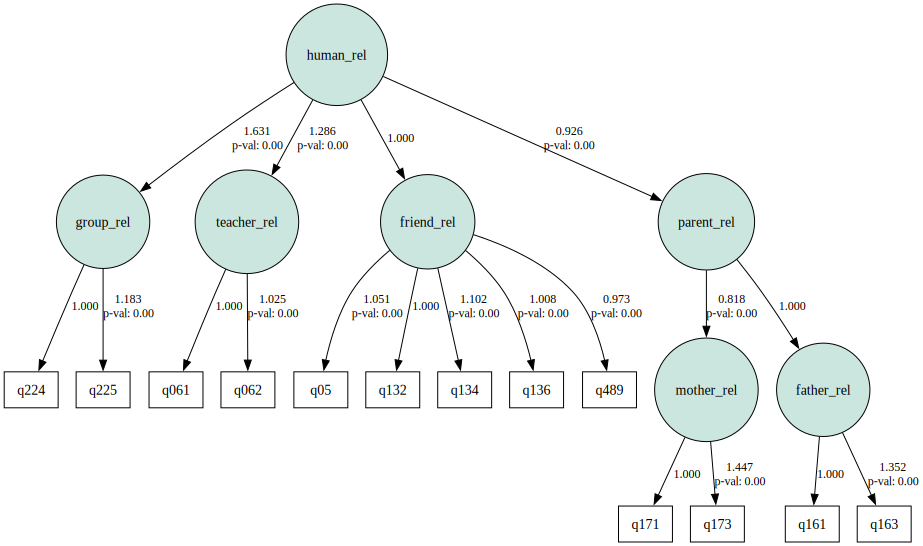

In [29]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\human_rel.png')

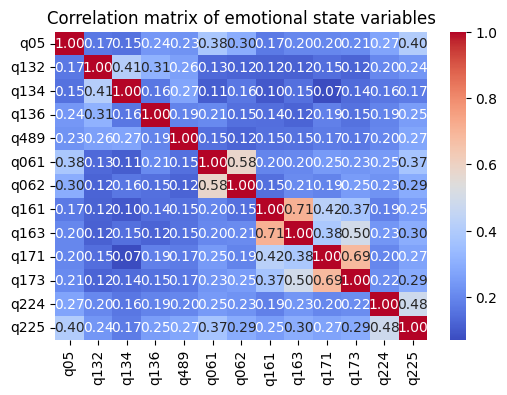

In [30]:
# 문제된 변수만 추출
rel_corr_df = df_rel[observed_vars].copy()

# 상관행렬 계산
corr_matrix = rel_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [31]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]
df['teacher_rel'] = factor_scores["teacher_rel"]
df['friend_rel'] = factor_scores["friend_rel"]
df['parent_rel'] = factor_scores["parent_rel"]
df['group_rel'] = factor_scores["group_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... q5422        wt academic_pressure academic_stress  \
0   아니오   아니오  ...   NaN  0.250048         -0.151269        0.002721   
1     예     예  ...   NaN  0.250048         -0.148003       -0.143278   
2     예     예  ...   NaN  0.250048         -0.190091       -0.065955   
3     예     예  ...   NaN  0.244036          0.052016        0.058772   
4   아니오     예  ...   NaN  0.244036          0.099197        0.294010   

  exam_anxiety human_rel teacher_rel friend_rel parent_rel group_rel  
0    -0.473646 -0.035736   -0.111158   

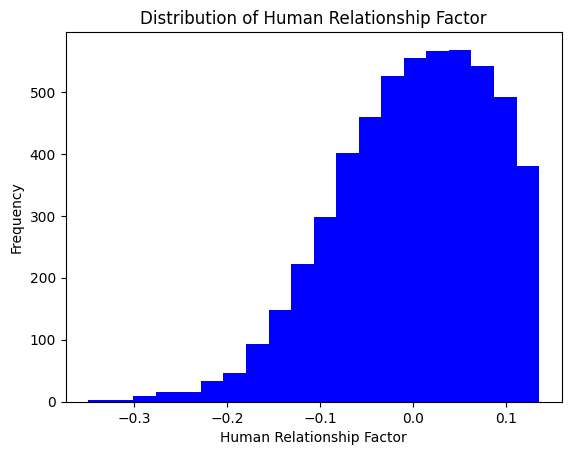

In [32]:
plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

# 정서적 상태

In [33]:
emo = df[['q221', 'q222', 'q223', 'q226', 'q23', 'q26']]
emo.isnull().sum()

q221    0
q222    0
q223    0
q226    0
q23     0
q26     0
dtype: int64

In [34]:
for i in emo.columns:
    display(emo[i].value_counts())

q221
매우 그렇다       1998
조금 그렇다       1508
보통이다         1225
별로 그렇지 않다     506
전혀 그렇지 않다     139
Name: count, dtype: int64

q222
매우 그렇다       1815
조금 그렇다       1546
보통이다         1256
별로 그렇지 않다     507
전혀 그렇지 않다     252
Name: count, dtype: int64

q223
매우 그렇다       1605
조금 그렇다       1464
보통이다         1454
별로 그렇지 않다     610
전혀 그렇지 않다     243
Name: count, dtype: int64

q226
전혀 그렇지 않다    1575
별로 그렇지 않다    1463
보통이다         1150
조금 그렇다        798
매우 그렇다        390
Name: count, dtype: int64

q23
대체로 행복한 편이다       3106
매우 행복하다           1063
별로 행복하지 않은 편이다     708
모르겠다               388
전혀 행복하지 않다         111
Name: count, dtype: int64

q26
보통이다       1865
약간 행복하다    1450
매우 행복하다    1340
약간 불행하다     575
매우 불행하다     146
Name: count, dtype: int64

In [35]:
emo = encoding(emo, ['q221', 'q222', 'q223'], category5_map)
emo = encoding(emo, ['q226'], reverse_category5_map)
emo = encoding(emo, ['q23'], happy_map)
emo = encoding(emo, ['q26'], how_happy_map)

In [36]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q221    5376 non-null   category
 1   q222    5376 non-null   category
 2   q223    5376 non-null   category
 3   q226    5376 non-null   category
 4   q23     5376 non-null   category
 5   q26     5376 non-null   category
dtypes: category(6)
memory usage: 32.9 KB


In [37]:
scaler = MinMaxScaler()
emo = pd.DataFrame(scaler.fit_transform(emo), columns=emo.columns)

In [38]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   q221    5376 non-null   float64
 1   q222    5376 non-null   float64
 2   q223    5376 non-null   float64
 3   q226    5376 non-null   float64
 4   q23     5376 non-null   float64
 5   q26     5376 non-null   float64
dtypes: float64(6)
memory usage: 252.1 KB


In [39]:
model_desc = """
emotional_state =~ q221 + q223 + q226 + q23
"""

In [40]:
emo['wt'] = df['wt']
observed_vars = ['q221', 'q223', 'q226', 'q23']
w_cov_df = calculate_covariance(emo, observed_vars)

적합도 지표:
                      Value
DoF               2.000000
DoF Baseline      6.000000
chi2             22.569467
chi2 p-value      0.000013
chi2 Baseline  5595.678654
CFI               0.996320
GFI               0.995967
AGFI              0.987900
NFI               0.995967
TLI               0.988960
RMSEA             0.043743
AIC              15.991604
BIC              68.709203
LogLik            0.004198 


모수 추정치:
               lval  op             rval  Estimate  Std. Err    z-value p-value
0             q221   ~  emotional_state  1.000000         -          -       -
1             q223   ~  emotional_state  1.542916  0.039907  38.662765     0.0
2             q226   ~  emotional_state  0.957764  0.032574  29.403152     0.0
3              q23   ~  emotional_state  1.093968  0.028468  38.427411     0.0
4  emotional_state  ~~  emotional_state  0.025571  0.001206  21.202969     0.0
5             q221  ~~             q221  0.049857   0.00109  45.754518     0.0
6             q223  ~

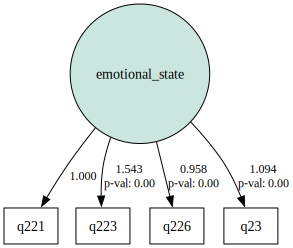

In [41]:
vif_df = compute_vif(emo, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, emo, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\emotional_state.png')

In [42]:
factor_scores = model.predict_factors(emo)

df["emotional_state"] = factor_scores["emotional_state"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...        wt academic_pressure academic_stress exam_anxiety  \
0   아니오   아니오  ...  0.250048         -0.151269        0.002721    -0.473646   
1     예     예  ...  0.250048         -0.148003       -0.143278    -0.232102   
2     예     예  ...  0.250048         -0.190091       -0.065955    -0.485246   
3     예     예  ...  0.244036          0.052016        0.058772     0.068234   
4   아니오     예  ...  0.244036          0.099197        0.294010    -0.158236   

  human_rel teacher_rel friend_rel parent_rel group_rel emotional_st

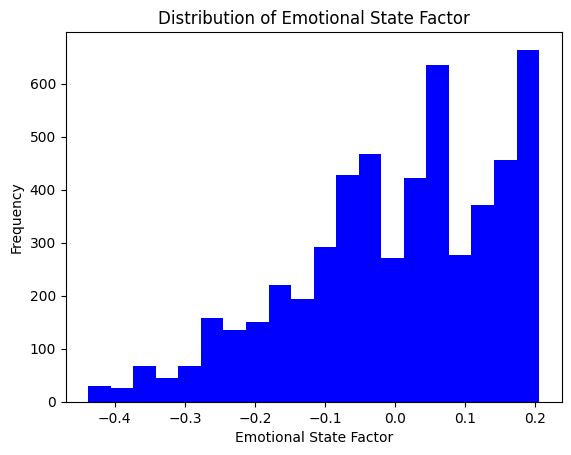

In [43]:
plt.hist(df["emotional_state"], bins=20, color='blue')
plt.title("Distribution of Emotional State Factor")
plt.xlabel("Emotional State Factor")
plt.ylabel("Frequency")
plt.show()

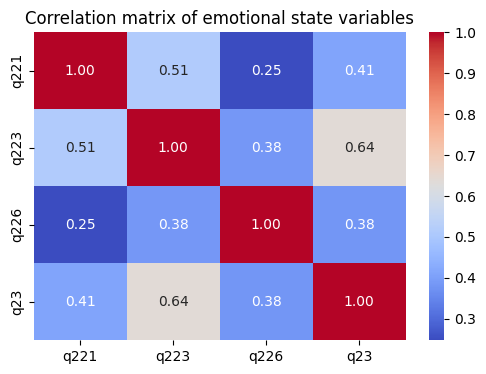

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문제된 변수만 추출
emo_vars = ['q221', 'q223', 'q226', 'q23']
emo_corr_df = emo[emo_vars].copy()

# 상관행렬 계산
corr_matrix = emo_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [45]:
print(df[df['q35'] == '있다'])

           id sex  birthy birthm                 area         size school  \
8     20009.0  남성  2003.0     7월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
25    20026.0  남성  2003.0     8월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
73    20074.0  여성  2008.0     5월      충청권(대전, 충남, 충북)         중소도시    중학생   
94    20095.0  여성  2003.0     3월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
95    20096.0  남성  2008.0     4월      충청권(대전, 충남, 충북)         중소도시    중학생   
...       ...  ..     ...    ...                  ...          ...    ...   
5196  25197.0  남성  2006.0     8월      호남권(광주, 전남, 전북)         중소도시    중학생   
5218  25219.0  남성  2007.0     6월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5225  25226.0  남성  2007.0     2월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5245  25246.0  여성  2007.0    11월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5343  25344.0  남성  2003.0     5월      수도권(서울, 경기, 인천)          대도시   고등학생   

     grade home1 home2  ...        wt academic_pressure academic_stress  \


# 학교 폭력 노출도

In [46]:
df_vio = df[['q33', 'q35', 'q351', 'q352']]

In [47]:
display(df_vio['q33'].value_counts())
display(df_vio['q35'].value_counts())
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q33
별로 심각하지 않다    1670
전혀 심각하지 않다    1646
보통이다          1313
약간 심각한 편이다     458
매우 심각하다        289
Name: count, dtype: int64

q35
없다    5207
있다     169
Name: count, dtype: int64

q351
1.0       98
2.0       24
3.0       14
5.0        9
4.0        8
모름/무응답     7
10.0       3
20.0       2
6.0        2
9.0        1
50.0       1
Name: count, dtype: int64

q352
1.0       69
2.0       31
3.0       18
4.0       14
10.0       9
모름/무응답     8
5.0        7
6.0        4
8.0        3
20.0       2
9.0        1
7.0        1
17.0       1
16.0       1
Name: count, dtype: int64

In [48]:
df_vio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q33     5376 non-null   category
 1   q35     5376 non-null   category
 2   q351    169 non-null    category
 3   q352    169 non-null    category
dtypes: category(4)
memory usage: 22.5 KB


In [49]:
df_vio = encoding(df_vio, ['q33'], how_serious_map)
df_vio = encoding(df_vio, ['q35'], is_or_not_map)
df_vio['q351'] = df_vio['q351'].replace({'모름/무응답' : 2})
df_vio['q351'] = df_vio['q351'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio['q352'] = df_vio['q352'].replace({'모름/무응답' : 2})
df_vio['q352'] = df_vio['q352'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio = null0(df_vio)
df_vio

,q33,q35,q351,q352
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,0,0,0.0,0.0
3,2,0,0.0,0.0
4,0,0,0.0,0.0
...,...,...,...,...
5371,0,0,0.0,0.0
5372,1,0,0.0,0.0
5373,3,0,0.0,0.0
5374,0,0,0.0,0.0


In [50]:
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q351
0.0    5207
1.0      98
2.0      71
Name: count, dtype: int64

q352
0.0    5207
2.0     100
1.0      69
Name: count, dtype: int64

In [51]:
model_desc = """
exposure_violence =~ q33 + q35 + q351 + q352
"""

In [52]:

df_vio['wt'] = df['wt']
observed_vars = ['q33', 'q35', 'q351', 'q352']
w_cov_df = calculate_covariance(df_vio, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_vio, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF                2.000000
DoF Baseline       6.000000
chi2              11.230035
chi2 p-value       0.003643
chi2 Baseline  25555.212192
CFI                0.999639
GFI                0.999561
AGFI               0.998682
NFI                0.999561
TLI                0.998916
RMSEA              0.029302
AIC               15.995822
BIC               68.713421
LogLik             0.002089 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0                q33   ~  exposure_violence  1.000000         -          -   
1                q35   ~  exposure_violence  1.225419  0.143113   8.562601   
2               q351   ~  exposure_violence  1.868277   0.21824   8.560674   
3               q352   ~  exposure_violence  2.026795  0.236724   8.561832   
4  exposure_violence  ~~  exposure_violence  0.017143  0.004017   4.268067   
5                q33  ~~                q33  1.234066  0.023808   51.83299   
6            

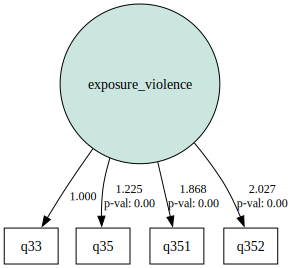

In [53]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\school_violence.png')


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_pressure academic_stress exam_anxiety human_rel  \
0   아니오   아니오  ...         -0.151269        0.002721    -0.473646 -0.035736   
1     예     예  ...         -0.148003       -0.143278    -0.232102  0.045446   
2     예     예  ...         -0.190091       -0.065955    -0.485246  0.040287   
3     예     예  ...          0.052016        0.058772     0.068234 -0.055024   
4   아니오     예  ...          0.099197        0.294010    -0.158236  0.083284   

  teacher_rel friend_rel parent_rel group_rel emotional_state  \
0  

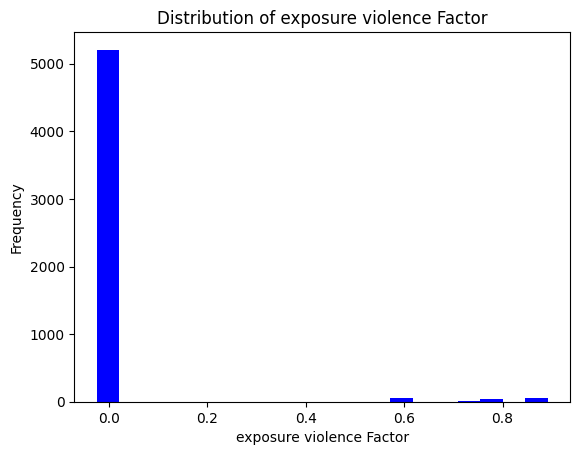

In [54]:
factor_scores = model.predict_factors(df_vio)

df["exposure_violence"] = factor_scores["exposure_violence"]

print(df.head())
plt.hist(df["exposure_violence"], bins=20, color='blue')
plt.title("Distribution of exposure violence Factor")
plt.xlabel("exposure violence Factor")
plt.ylabel("Frequency")
plt.show()

In [55]:
df['exposure_violence'].value_counts()

exposure_violence
-0.024538    1636
-0.024783    1625
-0.024293    1260
-0.024048     418
-0.023803     268
 0.607752      20
 0.891943      18
 0.765818      16
 0.607507      15
 0.891698      14
 0.892188      12
 0.607997       9
 0.607262       9
 0.765573       9
 0.766063       9
 0.766308       8
 0.891453       6
 0.891208       6
 0.733142       4
 0.733878       4
 0.733387       4
 0.733633       3
 0.765328       2
 0.608242       1
Name: count, dtype: int64

# 외모 및 신체 이미지

In [56]:
body = df[['q42', 'q43', 'q4812', 'q4813', 'q4814', 'q4815']]
body.isnull().sum()

q42      0
q43      0
q4812    0
q4813    0
q4814    0
q4815    0
dtype: int64

In [57]:
for i in body.columns:
    display(body[i].value_counts())

q42
160.0    361
170.0    315
165.0    263
158.0    246
163.0    243
        ... 
185.4      1
193.0      1
192.0      1
194.0      1
200.0      1
Name: count, Length: 241, dtype: int64

q43
60.0     269
50.0     266
55.0     238
53.0     195
70.0     191
        ... 
150.0      1
161.0      1
165.0      1
190.0      1
200.0      1
Name: count, Length: 229, dtype: int64

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

q4813
전혀 그렇지 않다    2346
별로 그렇지 않다    1112
보통이다          885
조금 그렇다        742
매우 그렇다        291
Name: count, dtype: int64

q4814
전혀 그렇지 않다    1984
별로 그렇지 않다    1168
보통이다         1064
조금 그렇다        825
매우 그렇다        335
Name: count, dtype: int64

q4815
전혀 그렇지 않다    2532
별로 그렇지 않다    1156
보통이다          838
조금 그렇다        597
매우 그렇다        253
Name: count, dtype: int64

In [58]:
body = encoding(body, ['q4812', 'q4813', 'q4814', 'q4815'], category5_map)
body = calculate_bmi(body, 'q42', 'q43')
body['obesity'] = body['bmi'].apply(lambda x: (
    0 if x < 18.5 else
    1 if x < 23 else
    2 if x < 25 else
    3 if x < 30 else
    4 if x < 35 else
    5
))

body['obesity'] = body['obesity'].astype('category')

In [59]:
scaler = MinMaxScaler()
body[['q42', 'q43']] = scaler.fit_transform(body[['q42', 'q43']])

In [60]:
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   q42      5317 non-null   float64 
 1   q43      5283 non-null   float64 
 2   q4812    5376 non-null   category
 3   q4813    5376 non-null   category
 4   q4814    5376 non-null   category
 5   q4815    5376 non-null   category
 6   bmi      5283 non-null   float64 
 7   obesity  5376 non-null   category
dtypes: category(5), float64(3)
memory usage: 153.4 KB


In [61]:
body.head(3)

,q42,q43,q4812,q4813,q4814,q4815,bmi,obesity
0,0.58,0.277778,0,0,0,0,28.04,3
1,0.60,0.194444,2,0,0,0,21.48,1
2,0.66,0.188889,2,2,1,1,19.60,1


In [62]:
model_desc = '''
body_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_stress + body_info

q4812 ~~ q4813
q4812 ~~ obesity
'''

In [63]:
body['wt'] = df['wt']
observed_vars = ['q4812', 'q4813', 'q4814','q4815', 'obesity', 'q42', 'q43']
w_cov_df = calculate_covariance(body, observed_vars)
vif_df = compute_vif(body, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, body, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                      Value
DoF               1.000000
DoF Baseline     10.000000
chi2             19.450122
chi2 p-value      0.000010
chi2 Baseline  6457.187876
CFI               0.997138
GFI               0.996988
AGFI              0.969878
NFI               0.996988
TLI               0.971383
RMSEA             0.058588
AIC              27.992764
BIC             120.248562
LogLik            0.003618 


모수 추정치:
                      lval  op                   rval  Estimate  Std. Err  \
0             body_stress   ~  body_image_experience  1.000000         -   
1               body_info   ~  body_image_experience  0.153791  0.037631   
2                   q4812   ~            body_stress  1.000000         -   
3                   q4813   ~            body_stress  0.724073  0.021249   
4                   q4814   ~            body_stress  1.149342  0.027202   
5                   q4815   ~            body_stress  0.945319  0.022608   
6                 obesity   ~             

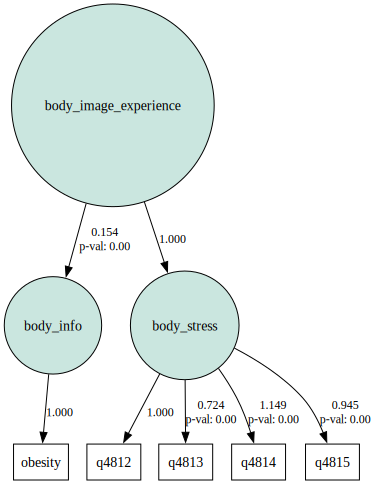

In [64]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\body_image_experience.png')

In [65]:
factor_scores = model.predict_factors(body)

df["body_image_experience"] = factor_scores["body_image_experience"]

print(df.head())


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_stress exam_anxiety human_rel teacher_rel  \
0   아니오   아니오  ...        0.002721    -0.473646 -0.035736   -0.111158   
1     예     예  ...       -0.143278    -0.232102  0.045446   -0.030554   
2     예     예  ...       -0.065955    -0.485246  0.040287    0.221778   
3     예     예  ...        0.058772     0.068234 -0.055024   -0.029132   
4   아니오     예  ...        0.294010    -0.158236  0.083284    0.240521   

  friend_rel parent_rel group_rel emotional_state exposure_violence  \
0   0.064802   0.213652 -0.146914

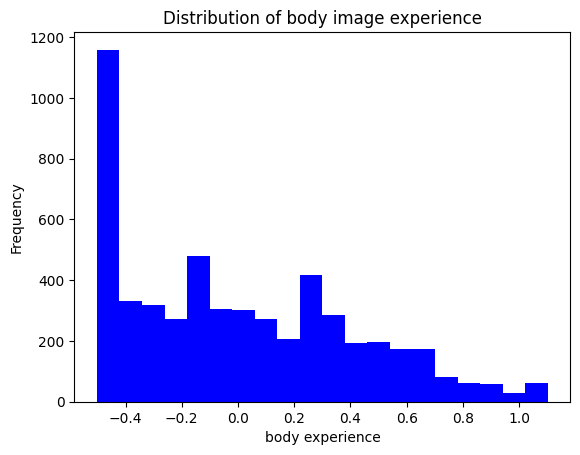

body_image_experience
-0.490741    554
-0.501723    238
-0.103438    145
 0.283865    107
-0.468777    104
            ... 
 0.116204      1
 0.619568      1
 0.145550      1
 0.448571      1
 0.801771      1
Name: count, Length: 1300, dtype: int64

In [66]:
plt.hist(df["body_image_experience"], bins=20, color='blue')
plt.title("Distribution of body image experience")
plt.xlabel("body experience")
plt.ylabel("Frequency")
plt.show()
df['body_image_experience'].value_counts()

# 부모의 지원

In [67]:
# 재정적 지원
financial_satis = ['q38', 'q4816', 'q4817']
time_support = ['q162', 'q172']
support = pd.concat([df[financial_satis], df[time_support]], axis=1)
support['need_money'] = df['q27'].apply(lambda x: 0 if x == '돈' else 1)
support.head(3)

,q38,q4816,q4817,q162,q172,need_money
0,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,1
1,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,1
2,중의 상,별로 그렇지 않다,별로 그렇지 않다,매우 그렇다,보통이다,1


In [68]:
for i in support.columns:
    display(support[i].value_counts())

q38
중의 상    2655
중의 하    1524
상의 하     623
상의 상     283
하의 상     230
하의 하      61
Name: count, dtype: int64

q4816
전혀 그렇지 않다    2779
별로 그렇지 않다    1193
보통이다          715
조금 그렇다        460
매우 그렇다        210
해당사항 없음        19
Name: count, dtype: int64

q4817
전혀 그렇지 않다    2549
별로 그렇지 않다    1263
보통이다          863
조금 그렇다        492
매우 그렇다        209
Name: count, dtype: int64

q162
매우 그렇다       2244
조금 그렇다       1190
보통이다         1130
별로 그렇지 않다     425
해당사항 없음       215
전혀 그렇지 않다     172
Name: count, dtype: int64

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

need_money
1    3752
0    1624
Name: count, dtype: int64

In [69]:
support = encoding(support, ['q38'], how_high_map)
support = not_applicable(support, ['q4816', 'q162','q172'])
support = encoding(support, ['q4816', 'q4817'], reverse_category5_map)
support = encoding(support, ['q162', 'q172'], category5_map)
support['need_money'].astype('category')
support.head(3)

,q38,q4816,q4817,q162,q172,need_money
0,1,4,4,4,4,1
1,1,4,4,4,4,1
2,1,3,3,4,2,1


In [70]:
scaler = MinMaxScaler()
support[['q4816', 'q4817', 'q162', 'q172']] = scaler.fit_transform(support[['q4816', 'q4817', 'q162', 'q172']])

In [71]:
support['q38'] = pd.Categorical(support['q38'], categories=[0, 1, 2], ordered=True)

In [72]:
support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   q38         5376 non-null   category
 1   q4816       5376 non-null   float64 
 2   q4817       5376 non-null   float64 
 3   q162        5376 non-null   float64 
 4   q172        5376 non-null   float64 
 5   need_money  5376 non-null   int64   
dtypes: category(1), float64(4), int64(1)
memory usage: 215.5 KB


In [73]:
model_desc = """
    financial_satis =~ q4816 + q4817 + need_money
    financial_environment =~ q38
    time_support =~ q162 + q172
    support =~ financial_satis + time_support
    financial_satis ~~ financial_environment
"""


In [74]:
support['wt'] = df['wt']
observed_vars = ['q38', 'q4816', 'q4817', 'q162', 'q172', 'need_money']
w_cov_df = calculate_covariance(support, observed_vars)

적합도 지표:
                      Value
DoF               5.000000
DoF Baseline     15.000000
chi2             96.604627
chi2 p-value      0.000000
chi2 Baseline  6668.182831
CFI               0.986231
GFI               0.985513
AGFI              0.956538
NFI               0.985513
TLI               0.958694
RMSEA             0.058383
AIC              31.964061
BIC             137.399259
LogLik            0.017970 


모수 추정치:
                      lval  op                   rval  Estimate  Std. Err  \
0         financial_satis   ~                support  1.000000         -   
1            time_support   ~                support  0.418267  0.000961   
2                   q4816   ~        financial_satis  1.000000         -   
3                   q4817   ~        financial_satis  1.027646  0.032284   
4              need_money   ~        financial_satis  0.498298  0.029271   
5                     q38   ~  financial_environment  1.000000         -   
6                    q162   ~           ti

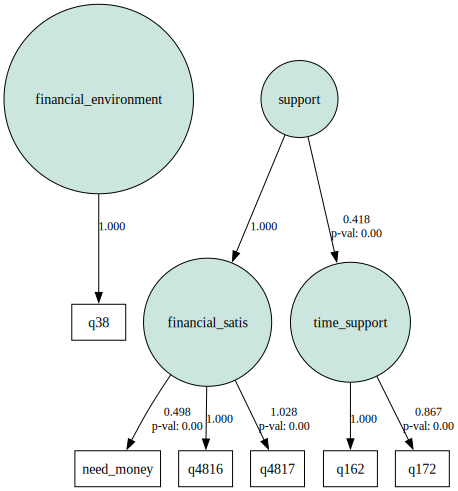

In [75]:
model = Model(model_desc)
model = fit_sem_model(model, support, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\support.png')

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... friend_rel parent_rel group_rel emotional_state  \
0   아니오   아니오  ...   0.064802   0.213652 -0.146914       -0.167932   
1     예     예  ...   0.093485   0.208344  0.059625        0.058954   
2     예     예  ...   0.003457  -0.054230  0.082943       -0.085814   
3     예     예  ...  -0.165142  -0.071565 -0.055185        0.044651   
4   아니오     예  ...   0.075157   0.205870  0.132077        0.205492   

  exposure_violence body_image_experience   support time_support  \
0         -0.024783             -0.468777  0.108238   

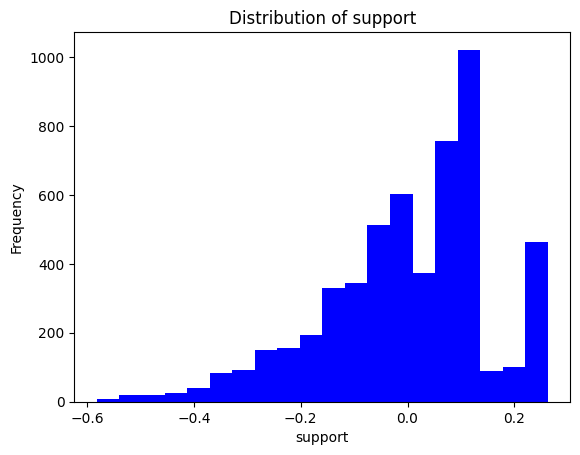

support
 0.108238    591
 0.262738    240
 0.096187    164
 0.098022    140
 0.001787    130
            ... 
-0.128966      1
 0.180034      1
-0.307610      1
-0.189030      1
-0.177173      1
Name: count, Length: 939, dtype: int64

In [76]:
factor_scores = model.predict_factors(support)

df["support"] = factor_scores["support"]
df['time_support'] = factor_scores["time_support"]
df['financial_satis'] = factor_scores["financial_satis"]
df['financial_environment'] = factor_scores["financial_environment"]
print(df.head())

plt.hist(df["support"], bins=20, color='blue')
plt.title("Distribution of support")
plt.xlabel("support")
plt.ylabel("Frequency")
plt.show()
df['support'].value_counts()

# 위험행동

In [77]:
df['q302'].value_counts()

q302
없다    1611
있다     316
Name: count, dtype: int64

In [78]:
crisis = df[['q287', 'q288', 'q289', 'q2810','q29', 'q31']]
crisis.isnull().sum()

q287     0
q288     0
q289     0
q2810    0
q29      0
q31      0
dtype: int64

In [79]:
crisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q287    5376 non-null   category
 1   q288    5376 non-null   category
 2   q289    5376 non-null   category
 3   q2810   5376 non-null   category
 4   q29     5376 non-null   category
 5   q31     5376 non-null   category
dtypes: category(6)
memory usage: 32.5 KB


In [80]:
crisis = encoding(crisis, ['q287', 'q288', 'q289', 'q2810'], yes_or_no_map)
crisis = encoding(crisis, ['q29', 'q31'], how_much_is_map)
# crisis = encoding(crisis, ['q302'], is_or_not_map)

crisis = null0(crisis)

In [81]:
model_desc = """
    substance =~  q287 + q288 + q289
    impulse =~ q29 + q31
    crisis_behavior =~ substance + q2810 + impulse
"""

In [82]:
crisis['wt'] = df['wt']
observed_vars = ['q287', 'q288', 'q289', 'q2810', 'q29', 'q31']
w_cov_df = calculate_covariance(crisis, observed_vars)

적합도 지표:
                      Value
DoF               7.000000
DoF Baseline     15.000000
chi2            105.541518
chi2 p-value      0.000000
chi2 Baseline  3487.132623
CFI               0.971619
GFI               0.969734
AGFI              0.935144
NFI               0.969734
TLI               0.939184
RMSEA             0.051177
AIC              27.960736
BIC             120.216534
LogLik            0.019632 


모수 추정치:
                lval  op             rval  Estimate  Std. Err    z-value  \
0         substance   ~  crisis_behavior  1.000000         -          -   
1           impulse   ~  crisis_behavior  4.635411  0.596668   7.768834   
2              q287   ~        substance  1.000000         -          -   
3              q288   ~        substance  1.782693  0.122343  14.571281   
4              q289   ~        substance  0.511073  0.035059  14.577701   
5               q29   ~          impulse  1.000000         -          -   
6               q31   ~          impulse  0.71632

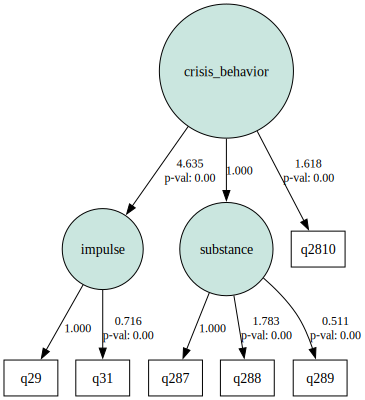

In [83]:
model = Model(model_desc)
model = fit_sem_model(model, crisis, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\crisis.png')

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... emotional_state exposure_violence body_image_experience  \
0   아니오   아니오  ...       -0.167932         -0.024783             -0.468777   
1     예     예  ...        0.058954         -0.024538             -0.366024   
2     예     예  ...       -0.085814         -0.024783              0.002915   
3     예     예  ...        0.044651         -0.024293              0.313212   
4   아니오     예  ...        0.205492         -0.024783              0.203523   

    support time_support financial_satis financial_environment  \
0  0.108

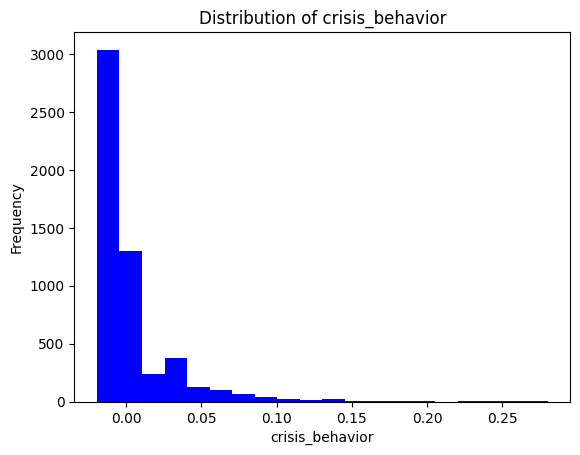

crisis_behavior
-0.019439    2599
 0.003816     482
-0.000076     473
-0.015546     352
 0.027071     170
             ... 
 0.168520       1
 0.095805       1
 0.186648       1
 0.094659       1
 0.164954       1
Name: count, Length: 83, dtype: int64

In [84]:
factor_scores = model.predict_factors(crisis)

df["crisis_behavior"] = factor_scores["crisis_behavior"]
df['impulse'] = factor_scores["impulse"]
df['substance'] = factor_scores["substance"]

print(df.head())

plt.hist(df["crisis_behavior"], bins=20, color='blue')
plt.title("Distribution of crisis_behavior")
plt.xlabel("crisis_behavior")
plt.ylabel("Frequency")
plt.show()
df['crisis_behavior'].value_counts()

# 조절효과 회귀분석 (OLS)

In [85]:
# df = df[df['school'] == '고등학생']
# df.head(3)

### emotional_state ~ academic_pressure + rel

In [86]:
df['interaction'] = df['academic_pressure'] * df['group_rel']

model = smf.ols('emotional_state ~ academic_pressure + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     1374.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:22:38   Log-Likelihood:                 4225.2
No. Observations:                5376   AIC:                            -8442.
Df Residuals:                    5372   BIC:                            -8416.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0002      0.00

In [87]:
df['interaction'] = df['academic_pressure'] * df['teacher_rel']

model = smf.ols('emotional_state ~ academic_pressure + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     651.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:22:38   Log-Likelihood:                 3527.9
No. Observations:                5376   AIC:                            -7048.
Df Residuals:                    5372   BIC:                            -7021.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.412e-05      0.00

In [88]:
df["interaction"] = df["academic_pressure"] * df["parent_rel"]

model = smf.ols("emotional_state ~ academic_pressure + parent_rel + interaction", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     843.9
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:22:38   Log-Likelihood:                 3732.4
No. Observations:                5376   AIC:                            -7457.
Df Residuals:                    5372   BIC:                            -7430.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0003      0.00

In [89]:
df['interaction'] = df['academic_pressure'] * df['friend_rel']

model = smf.ols('emotional_state ~ academic_pressure + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     1025.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:22:38   Log-Likelihood:                 3911.5
No. Observations:                5376   AIC:                            -7815.
Df Residuals:                    5372   BIC:                            -7789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0005      0.00

### impulse ~ violence + rel

In [90]:
df['interaction'] = df['exposure_violence'] * df['group_rel']

model = smf.ols('impulse ~ exposure_violence + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     133.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.00e-83
Time:                        02:22:38   Log-Likelihood:                -4144.0
No. Observations:                5376   AIC:                             8296.
Df Residuals:                    5372   BIC:                             8322.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0006      0.00

In [91]:
df['interaction'] = df['exposure_violence'] * df['teacher_rel']

model = smf.ols('impulse ~ exposure_violence + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     75.74
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           5.56e-48
Time:                        02:22:38   Log-Likelihood:                -4225.9
No. Observations:                5376   AIC:                             8460.
Df Residuals:                    5372   BIC:                             8486.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0001      0.00

In [92]:
df['interaction'] = df['exposure_violence'] * df['parent_rel']

model = smf.ols('impulse ~ exposure_violence + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     330.2
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          9.13e-197
Time:                        02:22:38   Log-Likelihood:                -3882.4
No. Observations:                5376   AIC:                             7773.
Df Residuals:                    5372   BIC:                             7799.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0003      0.00

In [93]:
df['interaction'] = df['exposure_violence'] * df['friend_rel']

model = smf.ols('impulse ~ exposure_violence + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     145.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.31e-90
Time:                        02:22:39   Log-Likelihood:                -4127.9
No. Observations:                5376   AIC:                             8264.
Df Residuals:                    5372   BIC:                             8290.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0006      0.00

### impulse ~ emotional_state + rel

In [94]:
df['interaction'] = df['emotional_state'] * df['group_rel']

model = smf.ols('impulse ~ emotional_state + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     426.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          2.76e-248
Time:                        02:22:39   Log-Likelihood:                -3763.6
No. Observations:                5376   AIC:                             7535.
Df Residuals:                    5372   BIC:                             7561.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0181      0.008     

In [95]:
df['interaction'] = df['emotional_state'] * df['teacher_rel']

model = smf.ols('impulse ~ emotional_state + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     419.7
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          5.83e-245
Time:                        02:22:39   Log-Likelihood:                -3771.2
No. Observations:                5376   AIC:                             7550.
Df Residuals:                    5372   BIC:                             7577.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0082      0.007     

In [96]:
df['interaction'] = df['emotional_state'] * df['parent_rel']

model = smf.ols('impulse ~ emotional_state + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     547.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          1.69e-310
Time:                        02:22:39   Log-Likelihood:                -3620.1
No. Observations:                5376   AIC:                             7248.
Df Residuals:                    5372   BIC:                             7275.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0174      0.007     

In [97]:
df['interaction'] = df['emotional_state'] * df['friend_rel']

model = smf.ols('impulse ~ emotional_state + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     425.1
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          8.43e-248
Time:                        02:22:39   Log-Likelihood:                -3764.7
No. Observations:                5376   AIC:                             7537.
Df Residuals:                    5372   BIC:                             7564.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0133      0.007     

In [98]:
df['interaction'] = df['emotional_state'] * df['human_rel']

model = smf.ols('impulse ~ emotional_state + human_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     427.4
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          5.42e-249
Time:                        02:22:39   Log-Likelihood:                -3761.9
No. Observations:                5376   AIC:                             7532.
Df Residuals:                    5372   BIC:                             7558.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0193      0.008     

### Y ~ X + support

In [99]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('emotional_state ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     564.3
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          8.14e-319
Time:                        02:22:39   Log-Likelihood:                 3430.7
No. Observations:                5376   AIC:                            -6853.
Df Residuals:                    5372   BIC:                            -6827.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0007      0.00

In [100]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('impulse ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     292.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          5.06e-176
Time:                        02:22:39   Log-Likelihood:                -3930.2
No. Observations:                5376   AIC:                             7868.
Df Residuals:                    5372   BIC:                             7895.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0028      0.00

In [101]:
df['interaction'] = df['academic_pressure'] * df['support']

model = smf.ols('parent_rel ~ academic_pressure + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             parent_rel   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     372.6
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          7.63e-220
Time:                        02:22:39   Log-Likelihood:                 1798.3
No. Observations:                5376   AIC:                            -3589.
Df Residuals:                    5372   BIC:                            -3562.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0015      0.00

In [102]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('parent_rel ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             parent_rel   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     697.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:22:39   Log-Likelihood:                 2174.5
No. Observations:                5376   AIC:                            -4341.
Df Residuals:                    5372   BIC:                            -4315.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0001      0.002     

In [103]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('impulse ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     520.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          6.28e-297
Time:                        02:22:40   Log-Likelihood:                -3651.4
No. Observations:                5376   AIC:                             7311.
Df Residuals:                    5372   BIC:                             7337.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0112      0.007     

In [104]:
df['interaction'] = df['emotional_state'] * df['support']

model = smf.ols('crisis_behavior ~ emotional_state + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        crisis_behavior   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     172.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          5.91e-107
Time:                        02:22:40   Log-Likelihood:                 11049.
No. Observations:                5376   AIC:                        -2.209e+04
Df Residuals:                    5372   BIC:                        -2.206e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0004      0.000     

In [105]:
df['interaction'] = df['human_rel'] * df['support']

model = smf.ols('academic_pressure ~ human_rel + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      academic_pressure   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     141.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.00e-88
Time:                        02:22:40   Log-Likelihood:                 1146.5
No. Observations:                5376   AIC:                            -2285.
Df Residuals:                    5372   BIC:                            -2259.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0036      0.003      1.260      

In [106]:
df['interaction'] = df['financial_environment'] * df['support']

model = smf.ols('emotional_state ~ financial_environment + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     327.5
Date:                Tue, 29 Apr 2025   Prob (F-statistic):          2.55e-195
Time:                        02:22:40   Log-Likelihood:                 3145.9
No. Observations:                5376   AIC:                            -6284.
Df Residuals:                    5372   BIC:                            -6258.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.00

In [107]:
df['interaction'] = df['academic_stress'] * df['support']

model = smf.ols('crisis_behavior ~ academic_stress + support + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        crisis_behavior   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     89.34
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.04e-56
Time:                        02:22:40   Log-Likelihood:                 10932.
No. Observations:                5376   AIC:                        -2.186e+04
Df Residuals:                    5372   BIC:                        -2.183e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.097e-05      0.000     

# 종합

In [108]:
everything = pd.concat([df_edu, df_rel, emo, body, df_vio, crisis, support], axis=1)

In [109]:
everything = everything.loc[:, ~everything.columns.duplicated()]

In [110]:
everything.head(3)

,q071,q072,q073,q074,q485,q486,q487,q488,wt,q05,...,q287,q288,q289,q2810,q29,q31,q38,q4816,q4817,need_money
0,0.000000,0.000000,0.000000,0.666667,0.75,0.50,1.0,0.0,0.250048,1.00,...,0,0,0,0,0,0,1,1.00,1.00,1
1,0.333333,0.333333,0.333333,0.333333,0.25,0.25,0.5,0.5,0.250048,0.75,...,0,0,0,0,0,0,1,1.00,1.00,1
2,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.5,0.5,0.250048,1.00,...,0,0,0,0,1,0,1,0.75,0.75,1


In [111]:
model_desc = """
academic_stress =~ q485 + q486 + q487 + q488
exam_anxiety =~ q072 + q073
academic_pressure =~ academic_stress + exam_anxiety

friend_rel =~ q132 + q134 + q136 + q489 + q05
teacher_rel =~ q061 + q062
father_rel =~ q161 + q163
mother_rel =~ q171 + q173
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225
human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel
father_rel ~~ mother_rel

emotional_state =~ q221 + q223 + q226 + q23

body_image_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_image_stress
body_image_experience ~~ body_info

exposure_violence =~ q35 + q351 + q352

substance =~ q287 + q288 + q289
impulse =~ q29 + q31
crisis_behavior =~ substance + q2810 + impulse

financial_satis =~ q4816 + q4817
financial_environment =~ q38
time_support =~ q162 + q172
support =~ financial_satis + time_support
q4816 ~~ q4817

# [1] 정서 상태(emotional_state)에 영향을 주는 요인들
emotional_state ~ academic_pressure          # 학업 압박이 정서 상태에 영향
emotional_state ~ human_rel                  # 인간 관계 → 정서 안정
emotional_state ~ parent_rel                 # 부모와의 관계 → 정서 상태
emotional_state ~ friend_rel                 # 친구 관계 → 정서 상태
emotional_state ~ body_image_experience      # 신체 이미지 경험 → 정서 상태
emotional_state ~ academic_stress            # 학업 스트레스 → 정서 상태
emotional_state ~ exposure_violence          # 폭력 노출 → 정서 상태
emotional_state ~ support

# [2] 충동성과 위기행동에 영향을 주는 정서 상태
impulse ~ emotional_state                    # 감정 상태 → 충동성
crisis_behavior ~ emotional_state            # 정서 상태 → 위기 행동
substance ~ emotional_state

# [3] 폭력 노출의 영향
impulse ~ exposure_violence                  # 폭력 경험 → 충동성
human_rel ~ exposure_violence                # 폭력 경험 → 인간관계 악화
substance ~ exposure_violence

# [5] 학업 스트레스 관련 경로
academic_pressure ~ human_rel
academic_pressure ~ teacher_rel
academic_pressure ~  parent_rel
academic_pressure ~ support
academic_pressure ~ emotional_state

academic_stress ~ human_rel                  # 좋은 인간 관계 → 학업 스트레스 완충
academic_stress ~ teacher_rel             # 시험 불안 → 학업 압박
academic_stress ~ parent_rel                 # 부모 관계 → 학업 스트레스
academic_stress ~ support
academic_stress ~ emotional_state

exam_anxiety ~ human_rel
exam_anxiety ~ teacher_rel
exam_anxiety ~  parent_rel
exam_anxiety ~ support
exam_anxiety ~ emotional_state

# [6] 인간 관계에 영향을 주는 경로
human_rel ~ academic_pressure                # 학업 압박 → 인간 관계 악화
human_rel ~ substance
human_rel ~ support
parent_rel ~ substance                       # 물질 사용 → 부모 관계 악화
parent_rel ~ academic_stress
parent_rel ~ academic_pressure
parent_rel ~ exam_anxiety
parent_rel ~ financial_environment          # 부모 관계 → 경제 환경
friend_rel ~ exposure_violence
teacher_rel ~ substance
teacher_rel ~ exposure_violence                # 폭력 노출 → 교사 관계 악화
teacher_rel ~ exam_anxiety
teacher_rel ~ academic_pressure

# [7] 충동성과 위기행동
impulse ~ academic_pressure                  # 학업 압박 → 충동성
impulse ~ friend_rel                         # 친구 관계 → 충동 억제
impulse ~ parent_rel
impulse ~ exam_anxiety
impulse ~ exposure_violence                 # 폭력 노출 → 충동성
impulse ~ support
impulse ~ human_rel

substance ~ academic_pressure      
substance ~ friend_rel
substance ~ parent_rel
substance ~ exam_anxiety
substance ~ exposure_violence      
substance ~ support            
substance ~ human_rel

crisis_behavior ~ academic_pressure          # 학업 압박 → 위기 행동
crisis_behavior ~ friend_rel
crisis_behavior ~ parent_rel
crisis_behavior ~ exam_anxiety
crisis_behavior ~ exposure_violence          # 폭력 노출 → 위기 행동
crisis_behavior ~ support                   # 가족 지원 → 위기 행동 완화
crisis_behavior ~ human_rel

# [8] 가족의 지원(support)의 영향
emotional_state ~ support                   # 가족 지원 → 정서 안정
human_rel ~ support                         # 가족 지원 → 인간관계 향상
academic_stress ~ support                   # 가족 지원 → 학업 스트레스 완충
academic_pressure ~ support                 # 가족 지원 → 학업 압박 완충
exam_anxiety ~ support                      # 가족 지원 → 시험 불안 완화
impulse ~ support                           # 가족 지원 → 충동성 억제
crisis_behavior ~ support                   # 가족 지원 → 위기 행동 완화
emotional_state ~ financial_environment     # 경제 환경 → 정서 안정
parent_rel ~ support                        # 부모 관계 → 가족 지원
parent_rel ~ financial_environment          # 부모 관계 → 경제 환경

"""

observed_vars = [
    'q072', 'q073', 'q485', 'q486', 'q487', 'q488', 'q221', 'q223', 'q226', 'q23',
    'q05','q132', 'q134', 'q136', 'q489', 'q061', 'q062', 'q161', 'q163', 'q171', 'q173', 'q224', 'q225',
    'q4812', 'q4813', 'q4814', 'q4815', 'obesity', 'q42', 'q43',
    'q33', 'q35', 'q351', 'q352',
    'q287', 'q288', 'q289', 'q2810','q29', 'q31',
    'q4816', 'q4817', 'q38', 'q162', 'q172'
                ]
w_cov_df = calculate_covariance(everything, observed_vars)
vif_df = compute_vif(everything, observed_vars)


# semplot(model, 'C:\\git_files\\education_analysis\\happy\\everything.png')
# report(model, 'C:\\git_files\\education_analysis\\happy\\report')

In [112]:
from semopy import Model

model = Model(model_desc)
# 원본 데이터를 직접 전달
res = model.fit(
    data=everything,   # DataFrame
    obj='DWLS',        # Diagonally Weighted Least Squares :contentReference[oaicite:3]{index=3}
    solver='SLSQP',    # 최적화 옵션은 그대로 사용
    clean_slate=True
)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)
# semplot(model, 'C:\\git_files\\education_analysis\\happy\\everything.png')
# report(model, 'C:\\git_files\\education_analysis\\happy\\report')

적합도 지표:
                        Value
DoF               731.000000
DoF Baseline      861.000000
chi2             9341.444187
chi2 p-value        0.000000
chi2 Baseline  153645.035688
CFI                 0.943643
GFI                 0.939201
AGFI                0.928389
NFI                 0.939201
TLI                 0.933621
RMSEA               0.046813
AIC               339.048702
BIC              1472.477082
LogLik              2.475649 


모수 추정치:
                 lval  op               rval  Estimate   Std. Err    z-value  \
0    academic_stress   ~  academic_pressure  1.000000          -          -   
1       exam_anxiety   ~  academic_pressure -3.083327  19.898061  -0.154956   
2         father_rel   ~         parent_rel  1.000000          -          -   
3         mother_rel   ~         parent_rel  0.811902   0.026082  31.129189   
4         friend_rel   ~          human_rel  1.000000          -          -   
..               ...  ..                ...       ...        ...      

In [113]:
# 각 하위 요인별 변수 목록
exam_anxiety_columns = ['q072', 'q073']
academic_stress_columns = ['q485', 'q486', 'q487', 'q488']
friend_rel_columns = ['q132', 'q134', 'q136', 'q489', 'q05']
teacher_rel_columns = ['q061', 'q062']
father_rel_columns = ['q161', 'q163']
mother_rel_columns = ['q171', 'q173']
parent_rel_columns = ['q161', 'q163', 'q171', 'q173']
group_rel_columns = ['q224', 'q225']
emotional_state_columns = ['q221', 'q223', 'q226', 'q23']
body_image_stress_columns = ['q4812', 'q4813', 'q4814', 'q4815']
exposure_violence_columns = ['q35', 'q351', 'q352']
substance_columns = ['q287', 'q288', 'q289']
impulse_columns = ['q29', 'q31']
financial_satis_columns = ['q4816', 'q4817']
time_support_columns = ['q162', 'q172']

for col in academic_stress_columns + exam_anxiety_columns + friend_rel_columns + teacher_rel_columns + \
        father_rel_columns + mother_rel_columns + parent_rel_columns + group_rel_columns + \
        emotional_state_columns + body_image_stress_columns + \
        exposure_violence_columns + substance_columns + impulse_columns + \
        financial_satis_columns + time_support_columns:
    # 각 열을 수치형으로 변환
    everything[col] = pd.to_numeric(everything[col], errors='coerce')


# 각 하위 요인별 Cronbach's α 계산 함수
def calculate_cronbach_alpha(columns):
    data = everything[columns]
    return pg.cronbach_alpha(data=data)[0]

# 각 하위 요인별 Cronbach's α 계산
cronbach_results = {}

# 각 하위 요인에 대해 Cronbach's α 계산
cronbach_results['academic_stress'] = calculate_cronbach_alpha(academic_stress_columns)
cronbach_results['exam_anxiety'] = calculate_cronbach_alpha(exam_anxiety_columns)
cronbach_results['friend_rel'] = calculate_cronbach_alpha(friend_rel_columns)
cronbach_results['teacher_rel'] = calculate_cronbach_alpha(teacher_rel_columns)
cronbach_results['father_rel'] = calculate_cronbach_alpha(father_rel_columns)
cronbach_results['mother_rel'] = calculate_cronbach_alpha(mother_rel_columns)
cronbach_results['parent_rel'] = calculate_cronbach_alpha(parent_rel_columns)
cronbach_results['group_rel'] = calculate_cronbach_alpha(group_rel_columns)
cronbach_results['emotional_state'] = calculate_cronbach_alpha(emotional_state_columns)
cronbach_results['body_image_stress'] = calculate_cronbach_alpha(body_image_stress_columns)
cronbach_results['exposure_violence'] = calculate_cronbach_alpha(exposure_violence_columns)
cronbach_results['substance'] = calculate_cronbach_alpha(substance_columns)
cronbach_results['impulse'] = calculate_cronbach_alpha(impulse_columns)
cronbach_results['financial_satis'] = calculate_cronbach_alpha(financial_satis_columns)
cronbach_results['time_support'] = calculate_cronbach_alpha(time_support_columns)

# Cronbach's α 값 출력
for factor, alpha in cronbach_results.items():
    print(f"{factor}의 Cronbach's α: {alpha:.3f}")


academic_stress의 Cronbach's α: 0.847
exam_anxiety의 Cronbach's α: 0.817
friend_rel의 Cronbach's α: 0.609
teacher_rel의 Cronbach's α: 0.723
father_rel의 Cronbach's α: 0.826
mother_rel의 Cronbach's α: 0.804
parent_rel의 Cronbach's α: 0.803
group_rel의 Cronbach's α: 0.647
emotional_state의 Cronbach's α: 0.742
body_image_stress의 Cronbach's α: 0.778
exposure_violence의 Cronbach's α: 0.959
substance의 Cronbach's α: 0.345
impulse의 Cronbach's α: 0.723
financial_satis의 Cronbach's α: 0.854
time_support의 Cronbach's α: 0.638


In [114]:
model = Model(model_desc)
model.fit(everything)

# 3. 추정 결과 추출
estimates = model.inspect()
estimates['p-value'] = pd.to_numeric(estimates['p-value'], errors='coerce')
significant_paths = estimates[(estimates['p-value'] < 0.05) & (estimates['op'] == '~')]

# 4. 유효한 식만 추출
valid_equations = []

for _, row in significant_paths.iterrows():
    lhs = row['lval']
    rhs = row['rval']
    op = row['op']
    Estimate = row['Estimate']
    pvalue = row['p-value']
    valid_equations.append(f"{lhs} | {op} | {rhs} | {Estimate} | {pvalue}")

# 중복 제거 + 정렬
valid_equations = sorted(set(valid_equations))

# 5. 최종 모델식 만들기
model_desc_valid = "\n".join(valid_equations)

# 6. 확인
print("✅ 유효한 가설만 남은 모델식:\n")
print(model_desc_valid)


✅ 유효한 가설만 남은 모델식:

academic_pressure | ~ | emotional_state | -5.185635430825243 | 6.645594978760272e-07
academic_pressure | ~ | human_rel | 4.723289258986477 | 0.00033938482879958265
academic_pressure | ~ | parent_rel | 0.7118069053099968 | 0.0004920230521239244
academic_pressure | ~ | support | 1.641334321640283 | 0.0056189435989519865
academic_pressure | ~ | teacher_rel | -2.2740405196031936 | 0.0
academic_stress | ~ | emotional_state | -0.5920642003147315 | 1.2556991709100629e-05
academic_stress | ~ | human_rel | 2.598559372735225 | 1.3384715558117932e-10
crisis_behavior | ~ | academic_pressure | 4.214949623593209 | 0.0
crisis_behavior | ~ | emotional_state | 5.09010393353676 | 0.0
crisis_behavior | ~ | exam_anxiety | 2.33951901114144 | 4.806710585114615e-11
crisis_behavior | ~ | exposure_violence | 1.6141377601957412 | 0.0
crisis_behavior | ~ | friend_rel | 8.941519285892085 | 0.0
crisis_behavior | ~ | human_rel | 8.526914503470278 | 0.0
crisis_behavior | ~ | parent_rel | -6.274078

In [115]:
model = Model(model_desc)
model.fit(everything)

# 3. 추정 결과 추출
estimates = model.inspect()
estimates['p-value'] = pd.to_numeric(estimates['p-value'], errors='coerce')
significant_paths = estimates[(estimates['p-value'] > 0.05) & (estimates['p-value'] <= 0.1) & (estimates['op'] == '~')]

# 4. 유효한 식만 추출
valid_equations = []

for _, row in significant_paths.iterrows():
    lhs = row['lval']
    rhs = row['rval']
    op = row['op']
    Estimate = row['Estimate']
    pvalue = row['p-value']
    valid_equations.append(f"{lhs} | {op} | {rhs} | {Estimate} | {pvalue}")

# 중복 제거 + 정렬
valid_equations = sorted(set(valid_equations))

# 5. 최종 모델식 만들기
model_desc_valid = "\n".join(valid_equations)

# 6. 확인
print("✅ 애매한한 가설만 남은 모델식:\n")
print(model_desc_valid)


✅ 애매한한 가설만 남은 모델식:

academic_stress | ~ | parent_rel | -0.3920930688309888 | 0.06322489044294866
emotional_state | ~ | body_image_experience | -0.09120125094407192 | 0.07360432968856978
exam_anxiety | ~ | parent_rel | 0.3996016801422829 | 0.0529949186460652
impulse | ~ | friend_rel | -0.4288890554047792 | 0.062390167386839
impulse | ~ | parent_rel | -0.1941425788996551 | 0.09443146989803042
parent_rel | ~ | human_rel | 1.008875809945514 | 0.09420141954352679
teacher_rel | ~ | substance | -0.2442821058127304 | 0.0975862030585255


In [116]:
def format_value(x):
    try:
        if str(x).strip() == '-':
            return x
        return f"{float(x):.6f}"
    except:
        return x

In [117]:
def standardize_estimates_full(estimates_df, data):
    """
    semopy 모델의 결과 DataFrame(estimates_df)에 대해 표준화 계수를 계산하는 함수.
    - 회귀 계수(op='~') 및 요인 부하량(op='=~')에 대해 계산.
    
    Parameters:
        estimates_df (pd.DataFrame): semopy의 model.inspect() 결과
        data (pd.DataFrame): 원자료 또는 잠재변수 점수가 포함된 데이터프레임

    Returns:
        pd.DataFrame: std_estimate 열이 추가된 DataFrame
    """
    std_estimates = []

    for _, row in estimates_df.iterrows():
        op = row['op']
        lhs = row['lval']
        rhs = row['rval']
        estimate = row['Estimate']

        if op == '~':  # 회귀 관계: lhs ~ rhs
            if lhs in data.columns and rhs in data.columns:
                try:
                    std_lhs = np.std(data[lhs], ddof=1)
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_beta = estimate * (std_rhs / std_lhs)
                    std_estimates.append(std_beta)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        elif op == '=~':  # 요인 부하량: latent =~ indicator
            if rhs in data.columns:
                try:
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_loading = estimate * std_rhs  # 잠재변수는 단위분산 가정
                    std_estimates.append(std_loading)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        else:
            std_estimates.append(np.nan)

    estimates_df['std_estimate'] = std_estimates
    return estimates_df


In [119]:
# factor_scores = model.predict_factors(everything)
# combined_df = pd.concat([everything.copy(), factor_scores], axis=1)
# estimates_df = model.inspect()
# std_estimates_df = standardize_estimates_full(estimates_df, combined_df)

# # 결과 확인
# pd.set_option('display.max_rows', None)
# display(std_estimates_df)
# pd.reset_option('display.max_rows')

In [120]:
# for col in ['Estimate', 'Std. Err', 'z-value', 'p-value', 'std_estimate']:
#     if col in std_estimates_df.columns:
#         std_estimates_df[col] = std_estimates_df[col].apply(format_value)

# std_estimates_df.to_csv('c:\\git_files\\education_analysis\\happy\\estimates.csv', index=False)
# df.to_csv('c:\\git_files\\education_analysis\\happy\\final_df.csv', index=False)